In [8]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

### Strip Analysis Functions

In [3]:
def locateStaffLines(s, delta = 3):
    medvals = np.median(s, axis=1)
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10])
    return np.array(idxs_lines)

In [6]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [7]:
def estimatePixelRow(midinum, m, b):
    return np.int(np.round(midinum * m + b))

### Get Strip of Sheet Music

In [9]:
test_image = Image.open(os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-1.png")).convert('L')

In [10]:
img_array = np.array(test_image)
#plt.imshow(img_array)
img_array.shape

(792, 612)

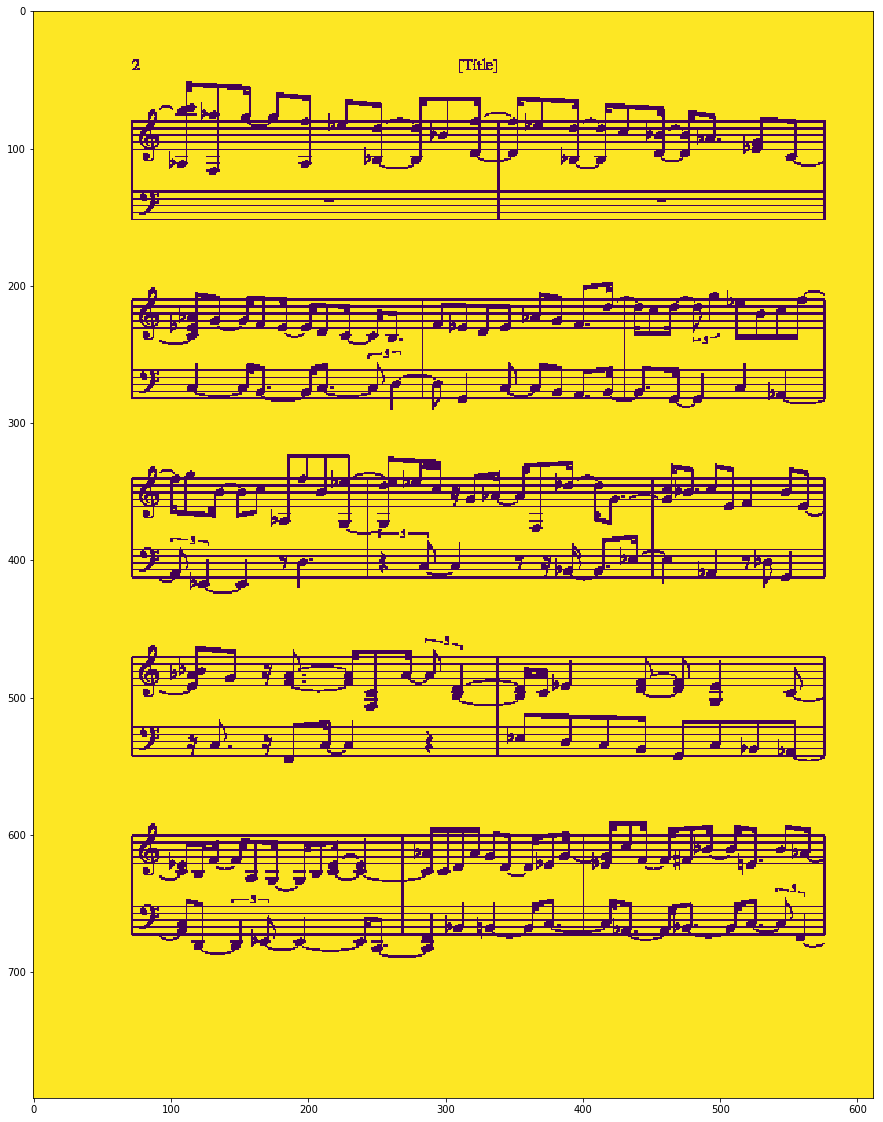

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(img_array)

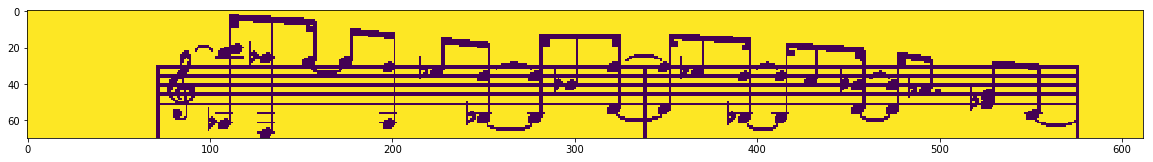

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(img_array[50:120, :])

So here's one strip.

In [13]:
strip = img_array[50:120, :]